### Reducing False Negatives in Breast Cancer Diagnosis

Objective: To develop a machine learning model that prioritizes the identification of malignant tumors. In clinical diagnostics, missing a cancer case (False Negative) is more critical than a false alarm; therefore, this project focuses on optimizing Recall and ensuring model Interpretability.

In [4]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


### 1. Library Imports
We begin by importing the necessary tools for data manipulation (`pandas`, `numpy`), visualization (`seaborn`, `matplotlib`), and the machine learning pipeline (`scikit-learn`).

In [33]:
csv_url = "https://huggingface.co/datasets/scikit-learn/breast-cancer-wisconsin/resolve/main/breast_cancer.csv"
df = pd.read_csv(csv_url)

# Drop irrelevant columns
df.drop(['id','Unnamed: 32'], axis=1, inplace=True)

df.head()


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 2. Loading the Dataset
We are utilizing the **Wisconsin Breast Cancer Dataset**. This dataset contains 569 instances of breast masses, each described by 30 features representing physical characteristics of cell nuclei. 

*Note: We remove the `id` and any empty columns immediately as they do not provide predictive value.*

In [16]:
# Encode diagnosis: M=1 (malignant), B=0 (benign)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Check mapping
df['diagnosis'].value_counts()


diagnosis
0    357
1    212
Name: count, dtype: int64

### 3. Target Variable Encoding
Machine learning models require numeric inputs. We map the `diagnosis` column from text to integers:
* **Malignant (M) → 1** (The "Positive" class we want to catch)
* **Benign (B) → 0** This setup allows us to calculate sensitivity (Recall) specifically for malignant cases.

In [18]:
# Check for missing values
df.isnull().sum()

# Check data types and summary statistics
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### 4. Exploratory Data Analysis
Before modeling, we inspect the data for missing values and distribution imbalances. Understanding the relationship between features such as how cell radius correlates with malignancy helps validate the clinical relevance of our features.

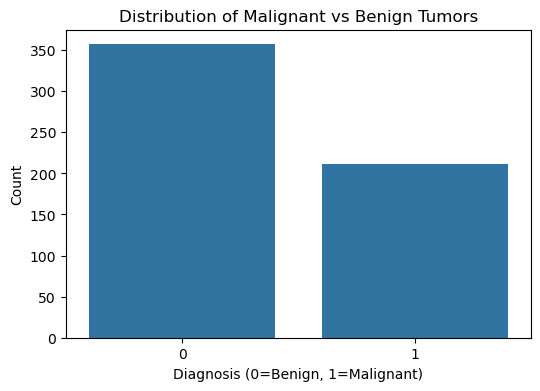

In [21]:
# 
plt.figure(figsize=(6,4))
sns.countplot(x='diagnosis', data=df)
plt.title("Distribution of Malignant vs Benign Tumors")
plt.xlabel("Diagnosis (0=Benign, 1=Malignant)")
plt.ylabel("Count")
plt.show()


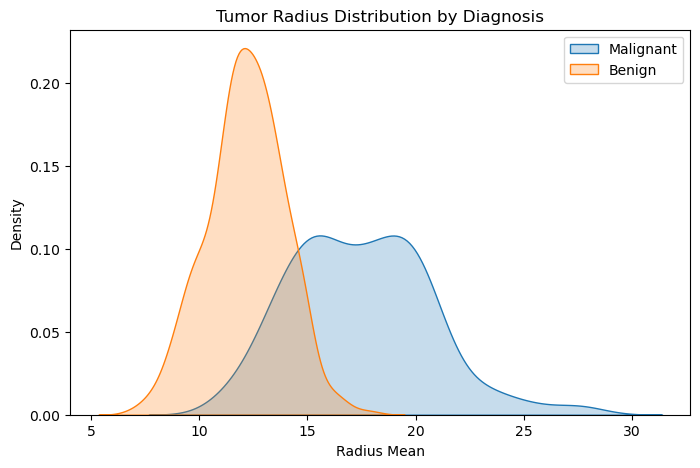

In [23]:
# Feature Distributions

# Compare radius_mean distribution for malignant vs benign
plt.figure(figsize=(8,5))
sns.kdeplot(df[df['diagnosis']==1]['radius_mean'], label='Malignant', fill=True)
sns.kdeplot(df[df['diagnosis']==0]['radius_mean'], label='Benign', fill=True)
plt.title("Tumor Radius Distribution by Diagnosis")
plt.xlabel("Radius Mean")
plt.ylabel("Density")
plt.legend()
plt.show()


### 5. Model Development (Logistic Regression)
We implement a **Pipeline** that combines two critical steps:
1. **StandardScaler**: Normalizes the data so that features with large ranges (like Area) don't overpower features with small ranges.
2. **Logistic Regression**: Chosen for its high interpretability, allowing us to see which features contribute most to a "Malignant" prediction.

In [24]:
# Features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Verify stratification
print("Training target distribution:\n", y_train.value_counts(normalize=True))
print("Testing target distribution:\n", y_test.value_counts(normalize=True))


Training target distribution:
 diagnosis
0    0.628141
1    0.371859
Name: proportion, dtype: float64
Testing target distribution:
 diagnosis
0    0.625731
1    0.374269
Name: proportion, dtype: float64


### 6. Evaluating Model Performance
We evaluate the model using a **Confusion Matrix** and a **Classification Report**. 
* **Recall** is our primary metric: We want to ensure that if a patient has cancer, the model identifies it.
* **ROC-AUC Score**: Used to measure the model's ability to distinguish between the two classes across different thresholds.

## Create Modeling Pipeline (Standard Scaling + Model)

In [25]:
## Logistic Regression Pipeline

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)


In [26]:
##Decision Tree (No scaling needed)

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)
y_pred_dt = dtree.predict(X_test)


Logistic Regression requires feature scaling; Decision Tree does not.

Using a pipeline ensures reproducible preprocessing and modeling.

## Model Evaluation

Logistic Regression Performance:

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       107
           1       0.98      0.94      0.96        64

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



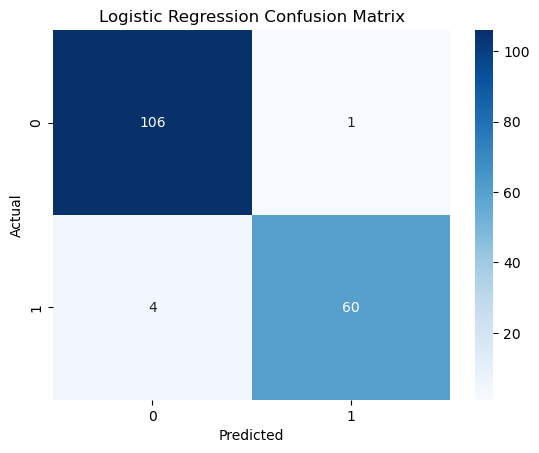

ROC-AUC: 1.00


In [27]:
# Logistic Regression

print("Logistic Regression Performance:\n")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr),
            annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
roc_auc_lr = roc_auc_score(y_test, pipeline_lr.predict_proba(X_test)[:,1])
print(f"ROC-AUC: {roc_auc_lr:.2f}")


Decision Tree Performance:

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       107
           1       0.89      0.84      0.86        64

    accuracy                           0.90       171
   macro avg       0.90      0.89      0.89       171
weighted avg       0.90      0.90      0.90       171



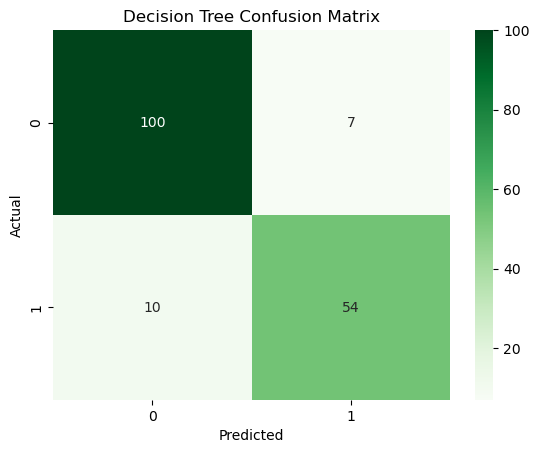

ROC-AUC: 0.89


In [28]:
# Decision Tree

print("Decision Tree Performance:\n")
print(classification_report(y_test, y_pred_dt))

sns.heatmap(confusion_matrix(y_test, y_pred_dt),
            annot=True, fmt='d', cmap='Greens')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc_dt = roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1])
print(f"ROC-AUC: {roc_auc_dt:.2f}")


Recall is prioritized to minimize false negatives.

ROC-AUC shows overall discrimination ability of the models.

## Threshold Tuning for High Recall (Optional, Original)

In [29]:
# Predict probabilities
y_prob = pipeline_lr.predict_proba(X_test)[:,1]

# Lower threshold to increase recall
threshold = 0.35
y_custom = (y_prob >= threshold).astype(int)

print("Classification Report with Custom Threshold (0.35):\n")
print(classification_report(y_test, y_custom))


Classification Report with Custom Threshold (0.35):

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       107
           1       0.98      0.97      0.98        64

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



Lowering the decision threshold increases recall (catches more malignant tumors) at the expense of precision. This demonstrates domain-specific optimization.

## Feature Importance (Interpretable Model)

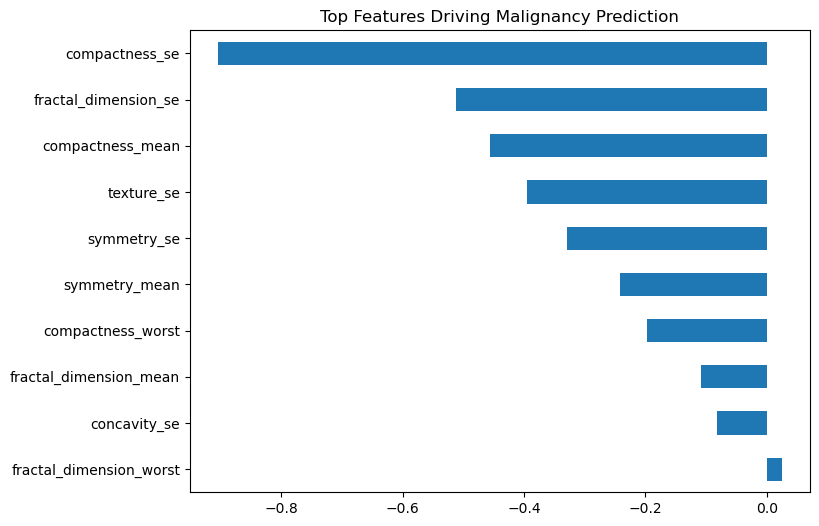

In [30]:
# Logistic Regression coefficients
coefficients = pd.Series(pipeline_lr.named_steps['model'].coef_[0], index=X.columns)
coefficients.sort_values(ascending=False).tail(10).plot(kind='barh', figsize=(8,6))
plt.title("Top Features Driving Malignancy Prediction")
plt.show()


### 8. Final Conclusion
The project successfully demonstrates that a transparent model like **Logistic Regression** can achieve high recall in cancer detection. By identifying **concave points**, **radius**, and **perimeter** as top predictors, we provide actionable insights that align with pathological observations. This workflow serves as a reliable framework for reducing false negatives in clinical settings.